In [2]:
import tensorflow as tf
import numpy as np
import datetime
import math
#%autoindent
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# read in data

In [12]:
filename = '/Users/Gene/Google Drive/UCI2016Winter/274C NRL NTWKS&DEEP LRNG Lec A /Project/Gene-Git/stock-prediction/Udemy-Tensorflow-Code/5582_04_Code/5582_04_01_Code/weather.npz'
data = np.load(filename)
daily = data['daily']
weekly = data['weekly']

num_weeks = len(weekly)
dates = np.array([datetime.datetime.strptime(str(int(d)),
                '%Y%m%d') for d in weekly[:,0]])
##########################################################
def assign_season(date):
    ''' Assign season based on meteorological season.
        Spring - from Mar 1 to May 31
        Summer - from Jun 1 to Aug 31
        Autumn - from Sep 1 to Nov 30
        Winter - from Dec 1 to Feb 28 (Feb 29 in a leap year)
    '''
    month = date.month
    # spring = 0
    if 3 <= month < 6:
        season = 0
    # summer = 1
    elif 6 <= month < 9:
        season = 1
    # autumn = 2
    elif 9 <= month < 12:
        season = 2
    # winter = 3
    elif month == 12 or month < 3:
        season = 3
    return season
############################################################

# There are 4 seasons
num_classes = 4

# and 5 variables
num_inputs = 5

# And a state of 11 numbers
state_size = 11

labels = np.zeros([num_weeks,num_classes])
# read and convert to one-hot
for i,d in enumerate(dates):
    labels[i,assign_season(d)] = 1

# extract and scale training data
train = weekly[:,1:]
train = train - np.average(train,axis=0)
train = train / train.std(axis=0)


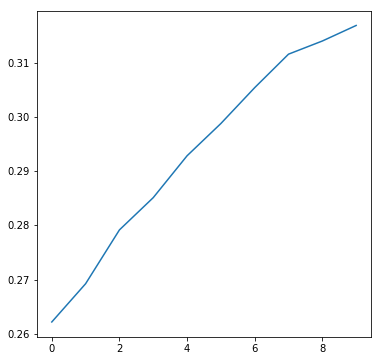

In [3]:
# Startup TensorFlow
sess = tf.InteractiveSession()

# These will be inputs
x = tf.placeholder("float", [None, num_inputs])
# TF likes a funky input to RNN
x_ = tf.reshape(x, [1, num_weeks, num_inputs])

## Known labels
# None works during variable creation to be
# unspecified size
y_ = tf.placeholder("float", [None,num_classes])

cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
outputs, states = tf.nn.dynamic_rnn(cell,x_,
            dtype=tf.nn.dtypes.float32, initial_state=None)

W1 = tf.Variable(tf.truncated_normal([state_size,num_classes],
                          stddev=1./math.sqrt(num_inputs)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_classes]))

# reshape the output for traditional usage
h1 = tf.reshape(outputs,[-1,state_size])

# Just initialize
sess.run(tf.initialize_all_variables())

# Logistic regression as usual
y = tf.nn.softmax(tf.matmul(h1, W1) + b1)

# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
     tf.nn.softmax_cross_entropy_with_logits(y + 1e-50, y_))

# How we train
train_step = tf.train.GradientDescentOptimizer(0.01
                    ).minimize(cross_entropy)

# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Actually train
epochs = 100
train_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train, y_: labels})
        train_acc[i//10] = A
    train_step.run(feed_dict={x: train, y_: labels})

import matplotlib.pyplot as plt
plt.ion()
plt.figure(figsize=(6, 6))
plt.plot(train_acc)


In [13]:
# can it be done with skflow?
import tensorflow.contrib.skflow as skflow
from sklearn import metrics

# To pass in data correctly
def listify(x):
    return [x]

# Undo the one_hot encoding
classes = [assign_season(d) for d in dates]

# One line model
classifier = skflow.TensorFlowRNNClassifier(rnn_size=11, 
    n_classes=4, cell_type='rnn', input_op_fn = listify,
    num_layers=8,
    steps=1000, optimizer='Adam',
    learning_rate=0.01, continue_training=True)

# Train model
classifier.fit(train, classes )

# simple accuracy
metrics.accuracy_score(classes,classifier.predict(train))

# confusion is easy in skflow
conf = metrics.confusion_matrix(classes,
            classifier.predict(train))
print(conf)

ImportError: No module named skflow

In [8]:
import tensorflow as tf
import numpy as np
import math
# Learn more skflow
# github.com/tensorflow/skflow
# Or install
# pip install \
# https://github.com/tensorflow/skflow/archive/master.zip
import tensorflow.contrib.skflow as skflow

# Learn more sklearn
# scikit-learn.org
import sklearn
from sklearn import metrics

%autoindent
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# Seed the data
np.random.seed(0)

# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']

# Look at some data
print(train[0])
print(labels[0])

# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
test, train = train[test_idx,:],\
              train[training_idx,:]
test_labels, train_labels = labels[test_idx],\
                        labels[training_idx]

sess = tf.InteractiveSession()

# Logistic Regression
# steps is number of total batches
# steps/batch_size = num_epochs
classifier = skflow.TensorFlowLinearClassifier(
            n_classes=5,
            steps=1000,
            optimizer='Adam',
            learning_rate=0.01,
            continue_training=True)

# One line training
classifier.fit(train.reshape([-1,36*36]),train_labels)

# sklearn compatible accuracy
sklearn.metrics.accuracy_score(test_labels,
        classifier.predict(test.reshape([-1,36*36])))

# Dense neural net
classifier = skflow.TensorFlowDNNClassifier(
            hidden_units=[10,5],
            n_classes=5,
            steps=1000,
            optimizer='Adam',
            learning_rate=0.01,
            continue_training=True)
classifier.fit(train.reshape([-1,36*36]),train_labels)

# simple accuracy
sklearn.metrics.accuracy_score(test_labels,
        classifier.predict(test.reshape([-1,36*36])))

# confusion is easy
conf = metrics.confusion_matrix(train_labels,
        classifier.predict(train.reshape([-1,36*36])))
print(conf)

### Convolutional net
def conv_skflow(X, y):
    X = tf.reshape(X, [-1, 36, 36, 1])
    # conv layer will compute 4 kernels for each 5x5 patch
    with tf.variable_scope('conv_layer'):
        # 5x5 convolution, pad with zeros on edges
        h1 = skflow.ops.conv2d(X, n_filters=4,
                filter_shape=[5, 5], 
                bias=True, activation=tf.nn.relu)
        # 2x2 Max pooling, no padding on edges
        p1 = tf.nn.max_pool(h1, ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1], padding='VALID')

    # Need to flatten conv output for use in dense layer
    p1_size = np.product(
              [s.value for s in p1.get_shape()[1:]])
    p1f = tf.reshape(p1, [-1, p1_size ])

    # densely connected layer with 32 neurons and dropout
    h_fc1 = skflow.ops.dnn(p1f,
            [32],
            activation=tf.nn.relu,
            dropout=0.5)
    return skflow.models.logistic_regression(h_fc1, y)

# Use generic estimator with our function
classifier = skflow.TensorFlowEstimator(
            model_fn=conv_skflow,
            n_classes=5,
            steps=1000,
            optimizer='Adam',
            learning_rate=0.01,
            continue_training=True)
classifier.fit(train,train_labels)

# simple accuracy
metrics.accuracy_score(test_labels,classifier.predict(test))

# URL for another skflow weight example
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/skflow/mnist_weights.py

# Convolutional Layer Weights
print(classifier.get_tensor_value(
        'conv_layer/convolution/filters:0'))
print(classifier.get_tensor_value(
        'conv_layer/convolution/bias:0'))

# Dense Layer
print(classifier.get_tensor_value(
        'dnn/layer0/Linear/Matrix:0'))

# Logistic weights
print(classifier.get_tensor_value(
        'logistic_regression/weights:0'))





ImportError: No module named skflow

In [7]:
X=np.array([[1,2],[3,4],[5,6]])
print X.size

6


In [10]:
#X=np.reshape(X,(X.size,))
X=np.reshape(X,(X.size,))
print X.shape
print X


TypeError: reshape() takes at least 2 arguments (1 given)